In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm
import os, sys
from PIL import Image
import gc
import time
import math
import numpy as np
import numpy.ma as ma
#import keyboard
import matplotlib
from scipy.stats import lognorm
from astropy.io import fits
from scipy.stats import mode
import time
import ast
import matplotlib.pyplot as plt
import math
import fnmatch as fnm
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from scipy.io import readsav
import csv
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import LimbSpectralTool_getL1CData_v20 as gsi_l1c
import LimbSpectralTool_InteractiveTool_DN_v20 as spectralTool
from matplotlib.widgets import TextBox
import matplotlib.patches as patches
from collections import OrderedDict
from scipy import interpolate
import matplotlib.image as image
import matplotlib.cbook as cbook
import matplotlib.colors as colors
from scipy import stats
import warnings
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

In [46]:
version = 'v21'

In [47]:
#Directory where magnetic field map ('bfield_smoothed.npy') and spectral templates are stored ('templates_.....npy')
map_and_data_dir = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir' #UPDATE FOR EACH NEW SYSTEM
map_img = np.load(map_and_data_dir+'\\magneticFieldMaps\\bfield_smoothed.npy') 
templates512 = np.load(map_and_data_dir+'\\DN_templates\\templates_512_DN.npy', allow_pickle=True)
templates256 = np.load(map_and_data_dir+'\\DN_templates\\templates_256_DN.npy', allow_pickle=True)

#set colorbar for magnetic field map
mag_cmap = plt.get_cmap('Blues')
mag_cmap.set_bad((1, 1, 1))

#Directory where L1C fits files are stored
#ben Dir for testing and troubleshooting:
#dir_to_dataFiles = r'C:\Users\benja\Documents\l1c_adrienne_20Jan2022\all_fits_files'

#Adrienne Dir - uncomment the following line and comment out Ben's dir on your machine
dir_to_dataFiles = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\all_fits_files' #insert your 'all_fits_file' folder directory here


#directory where v21 npy files are stored
#ben Dir for testing and troubleshooting:
#dir_to_v21 = r'C:\Users\benja\Documents\l1c_adrienne_20Jan2022\npy_v21_06Feb2022'

#Adrienne Dir - uncomment the following line and comment out Ben's dir on your machine
dir_to_v21 = r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\npy_v21_01Mar2022' #Insert your 'npy_v21_06Feb2022' directory here

In [48]:
#set colorbar for magnetic field map
mag_cmap = plt.get_cmap('Blues')
mag_cmap.set_bad((1, 1, 1))

wav_tmpl256 = templates256.item()['wavelength']
co_tmpl256 = templates256.item()['co_cameron']
uvd_tmpl256 = templates256.item()['co2p_uvd']           
no_tmpl256 = templates256.item()['no_nightglow']
wav_tmpl512 = templates512.item()['wavelength']
co_tmpl512 = templates512.item()['co_cameron']
uvd_tmpl512 = templates512.item()['co2p_uvd']           
no_tmpl512 = templates512.item()['no_nightglow']

In [49]:
def plot_spectrum_in_DN_with_templates(wav_DN, spec_DN, orb, scan, Pr, filename):
    if wav_DN.shape == (364,):
        #use 512 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl256, co_tmpl256, uvd_tmpl256
    #DN/nm PLOT
    plt.figure(figsize=(12, 3))
    plt.plot(wav_DN, spec_DN, '--o', c='k', markersize=3.5)
    plt.xlabel("wavelength [nm]")
    plt.xlim(right=325)
    plt.title(f'l1c orbit {orb} scan {scan}, P. r (CO, UVD) = {Pr}\n{filename}')
    maxCO = np.nanmax(spec_DN[:np.where(wav_DN <= 250)[0][-1]])
    maxUVD = np.nanmax(spec_DN[np.where(wav_DN >= 275)[0][0]:np.where(wav_DN <= 300)[0][-1]])
    plt.xlim(np.nanmin(wav_DN), np.nanmax(wav_DN))                  
    plt.plot(wav_tmpl_DN, co_tmpl_DN*maxCO + uvd_tmpl_DN*maxCO, color='purple', alpha=0.7)
    plt.ylabel('DN/nm')
    plt.show()

In [50]:
#Load npy files v21

v21npyFiles = gsi_l1c.find_all('*.npy*', dir_to_v21)
len(v21npyFiles)

84

In [51]:
DN_spectra, DN_wave, orbits, scans, pearsonRs, MSO_lat, MSO_lon, lats, lons, LTs, SZAs, filenames, ratios = [], [], [], [], [], \
                                                                                            [], [], [], [], [], [], [], []

for i in range(len(v21npyFiles)):
    data = np.load(v21npyFiles[i], allow_pickle=True)

    
    spectrum_DN = np.array(data[3], dtype=np.float64)
    waveDN = np.array(data[1], dtype=np.float64) # wavelength values #nm
    orbit, scan = int(np.array(data[12])[0]), int(np.array(data[12])[1]) # orbit and scan of interest
    MSOlats = np.array(data[17], dtype=np.float64)
    MSOlons = np.array(data[16], dtype=np.float64)
    latitudes = np.array(data[5], dtype=np.float64)
    longitudes = np.array(data[4], dtype=np.float64)
    localTimes = np.array(data[9], dtype=np.float64)
    solarZeniths = np.array(data[18], dtype=np.float64)
    filename = np.array(data[13])
    comlr = np.array(data[10], dtype=np.float64)
    uvdmlr = np.array(data[11], dtype=np.float64)
    
    #print(spectrum_DN.shape)
    
    DN_spectra.append(spectrum_DN)
    DN_wave.append(waveDN)
    orbits.append(orbit)
    scans.append(scan)
    MSO_lat.append(MSOlats)
    MSO_lon.append(MSOlons)
    lats.append(latitudes)
    lons.append(longitudes)
    LTs.append(localTimes)
    SZAs.append(solarZeniths)
    filenames.append(filename)
    ratios.append(np.mean(comlr)/np.mean(uvdmlr))
    
    if waveDN.shape > (256,):
        #use 512 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl0, co_tmpl0, uvd_tmpl0 = wav_tmpl256, co_tmpl256, uvd_tmpl256
    
    summedSpectrumMax_DN = np.nanmax(spectrum_DN[:np.where(waveDN <= 250)[0][-1]])
    co_tmpl_moved_DN = co_tmpl0*summedSpectrumMax_DN
    uvd_tmpl_moved_DN = uvd_tmpl0*summedSpectrumMax_DN
    
    minWavCO, maxWavCO = 185, 255
    conditionDNleftCO, conditionDNrightCO = np.where(waveDN <= minWavCO)[0][-1], np.where(waveDN <= maxWavCO)[0][-1]
    conditionTmplLeftCO, conditionTmplRightCO = np.where(wav_tmpl0 <= minWavCO)[0][-1], np.where(wav_tmpl0 <= maxWavCO)[0][-1]
    tempCO_pearson = co_tmpl_moved_DN[conditionTmplLeftCO:conditionTmplRightCO]
    specCO_pearson = spectrum_DN[conditionDNleftCO:conditionDNrightCO]
    
    if specCO_pearson.shape[0] - tempCO_pearson.shape[0] == 2:
        specCO_pearson = specCO_pearson[1:-1]
    if specCO_pearson.shape[0] - tempCO_pearson.shape[0] == 1:
        specCO_pearson = specCO_pearson[:-1]
    #print(tempCO_pearson.shape, specCO_pearson.shape)

    rCO, p = stats.pearsonr(tempCO_pearson, specCO_pearson)
    r_co = round(rCO, 2)

    #uvd pearson-r
    minWavUVD, maxWavUVD = 270, 300
    conditionDNleftUVD, conditionDNrightUVD = np.where(waveDN <= minWavUVD)[0][-1], np.where(waveDN <= maxWavUVD)[0][-1]
    conditionTmplLeftUVD, conditionTmplRightUVD = np.where(wav_tmpl0 <= minWavUVD)[0][-1], np.where(wav_tmpl0 <= maxWavUVD)[0][-1]
    tempUVD_pearson = uvd_tmpl_moved_DN[conditionTmplLeftUVD:conditionTmplRightUVD]
    specUVD_pearson = spectrum_DN[conditionDNleftUVD:conditionDNrightUVD]
    
    if specUVD_pearson.shape[0] - tempUVD_pearson.shape[0] == 2:
        specUVD_pearson = specUVD_pearson[1:-1]
    if specUVD_pearson.shape[0] - tempUVD_pearson.shape[0] == 1:
        specUVD_pearson = specUVD_pearson[:-1]
    #print(tempUVD_pearson.shape, specUVD_pearson.shape)
    
    rUVD, p = stats.pearsonr(tempUVD_pearson, specUVD_pearson)
    r_uvd = round(rUVD, 2)
    
    pearsonRs.append((r_co, r_uvd))
                     
DN_spectra = np.array(DN_spectra)
DN_wave = np.array(DN_wave)
all_ratios = np.array(np.round(ratios,2))

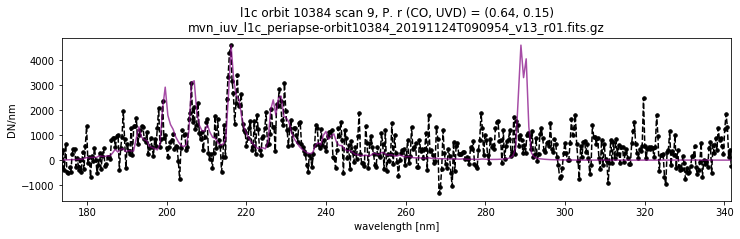

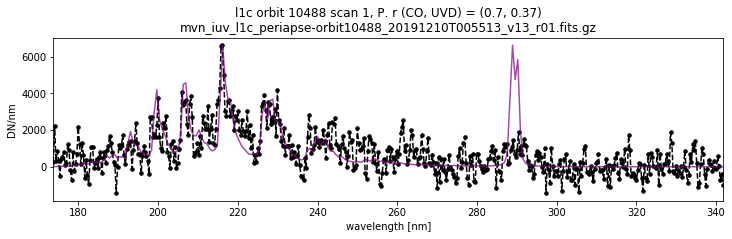

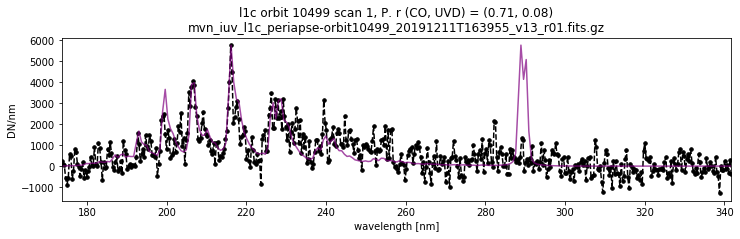

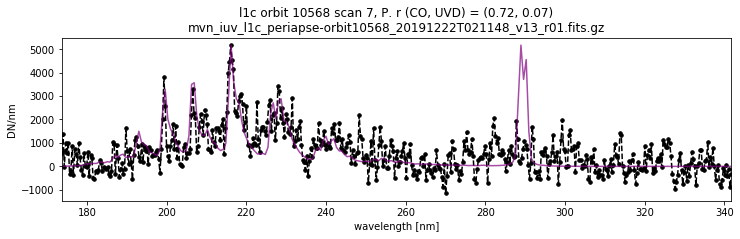

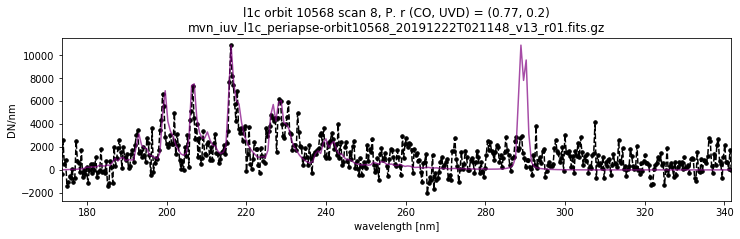

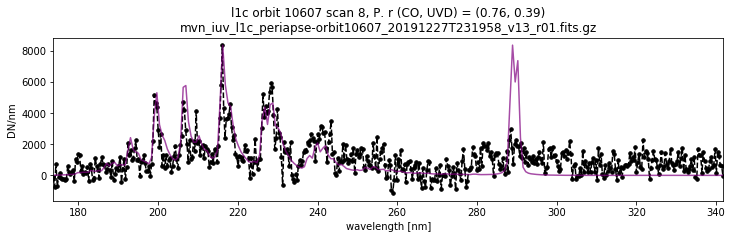

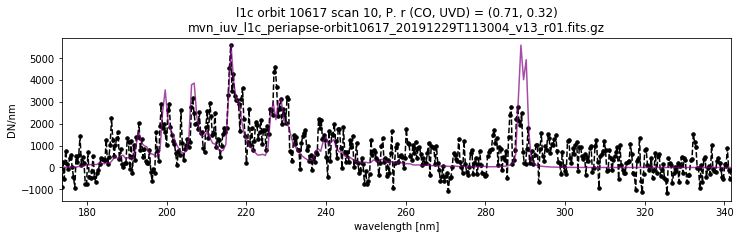

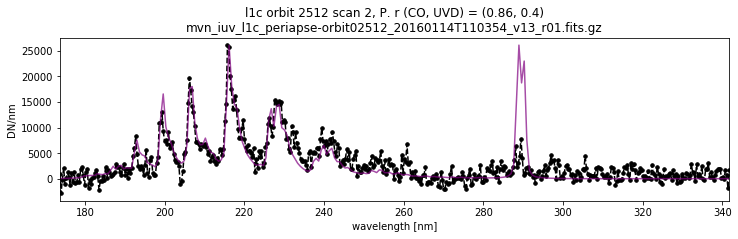

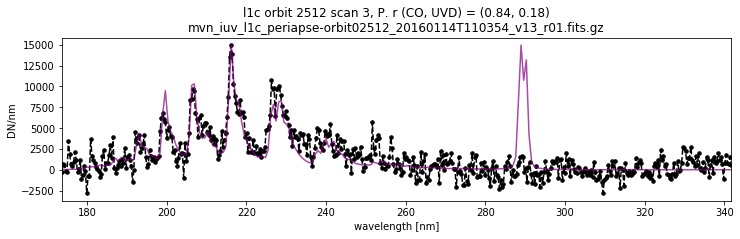

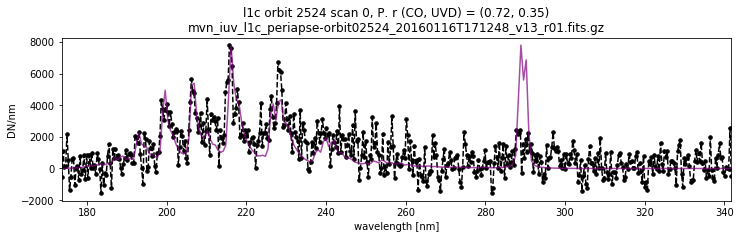

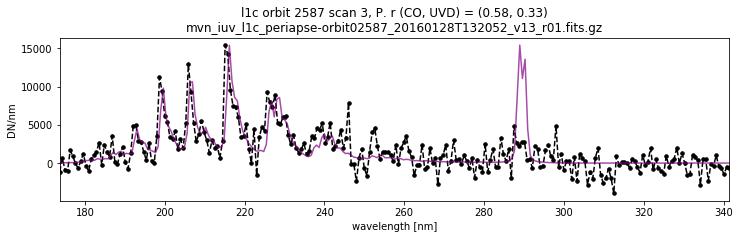

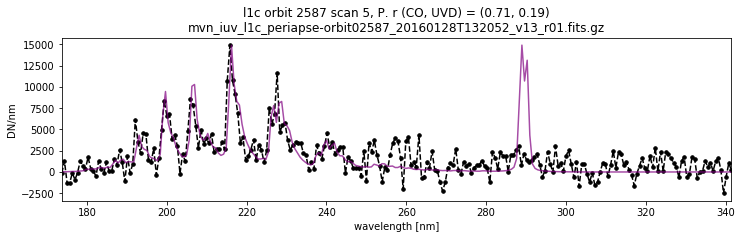

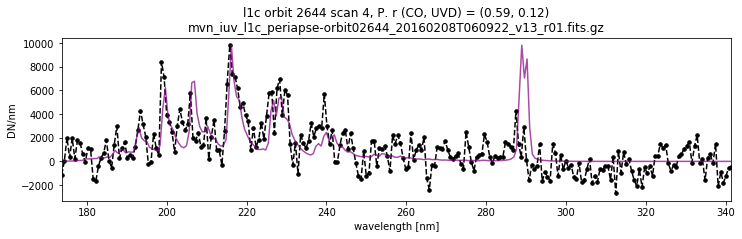

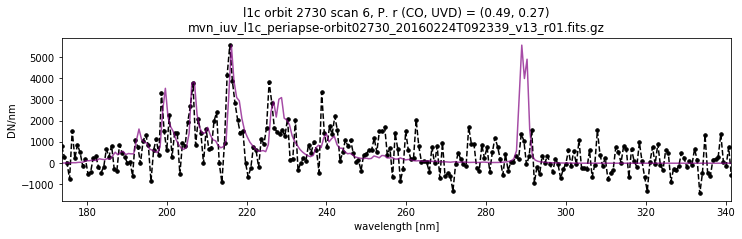

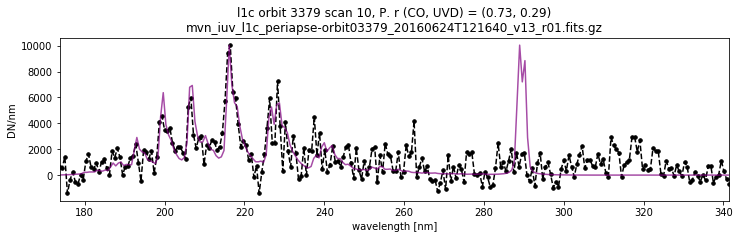

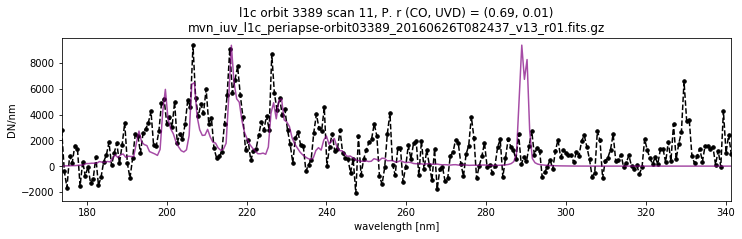

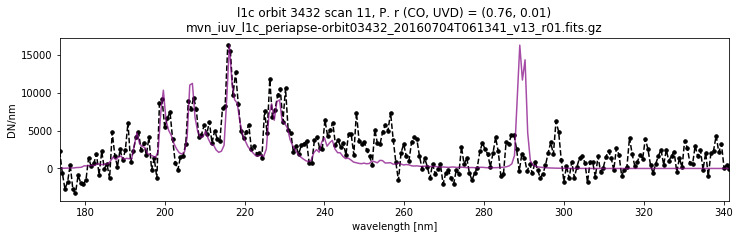

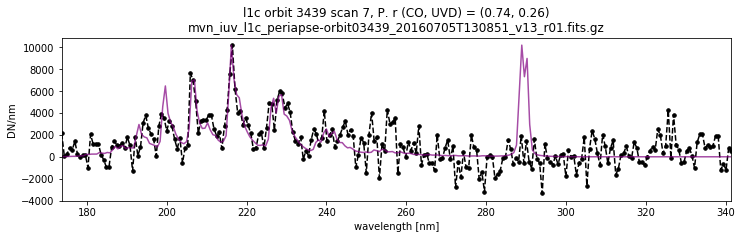

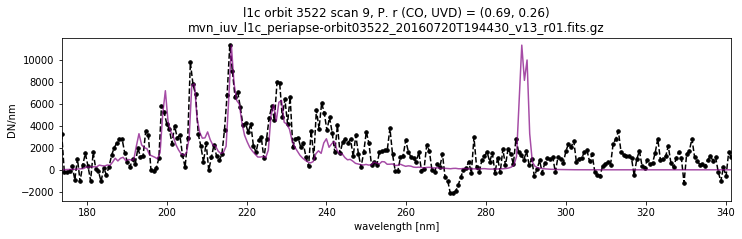

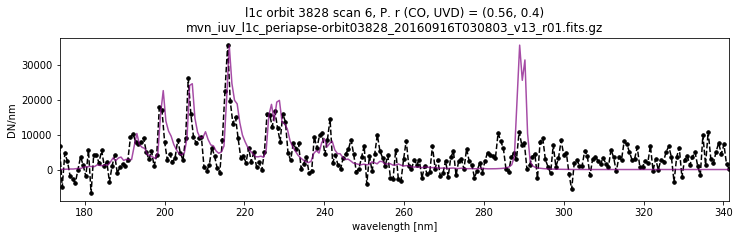

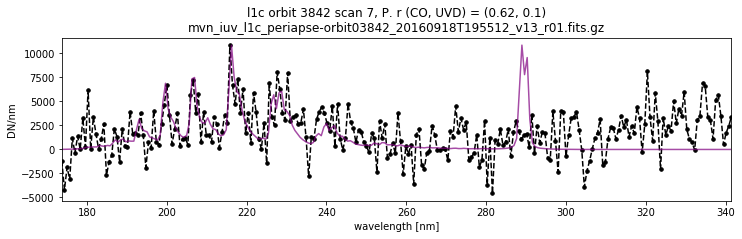

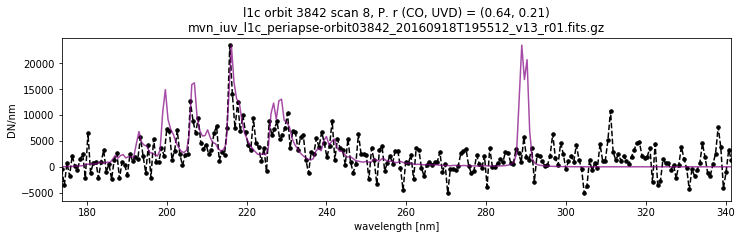

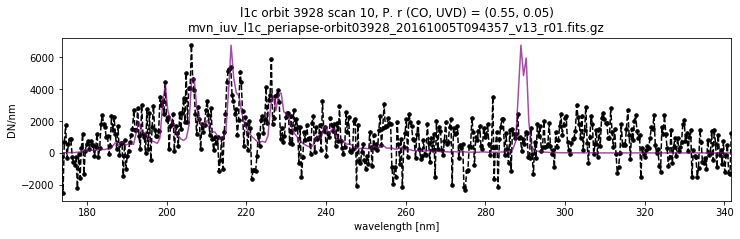

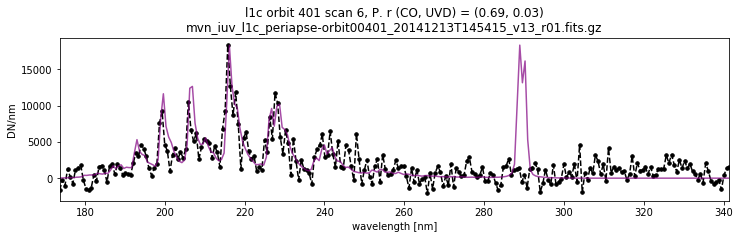

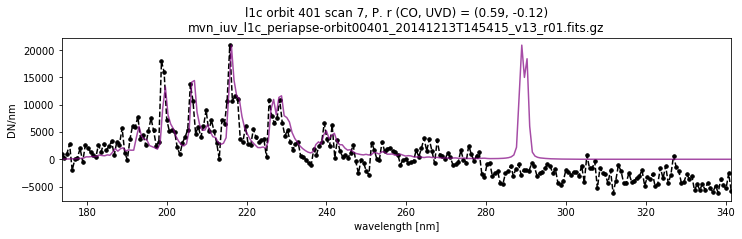

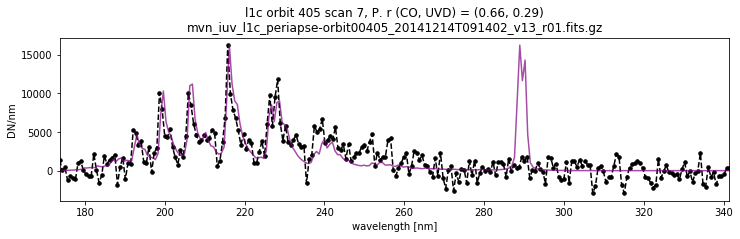

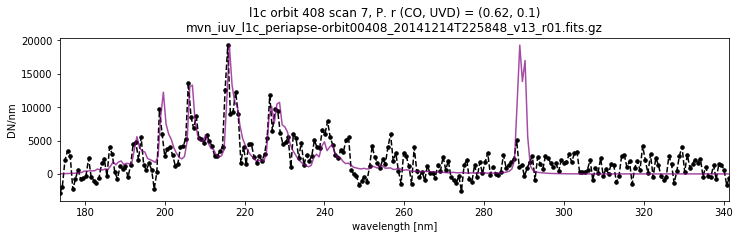

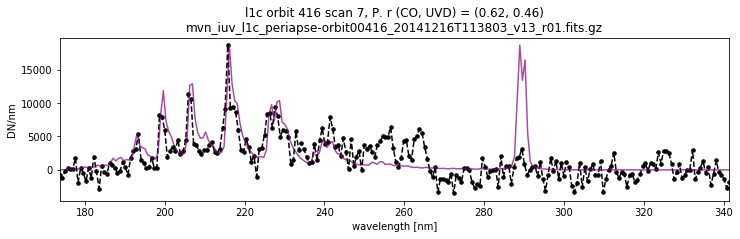

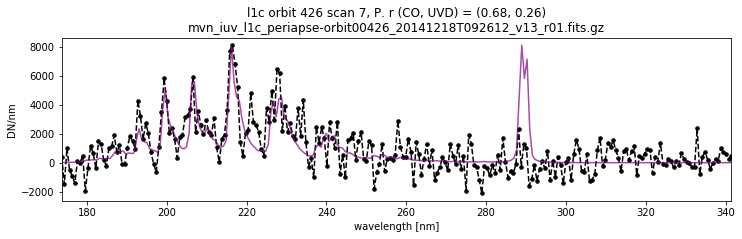

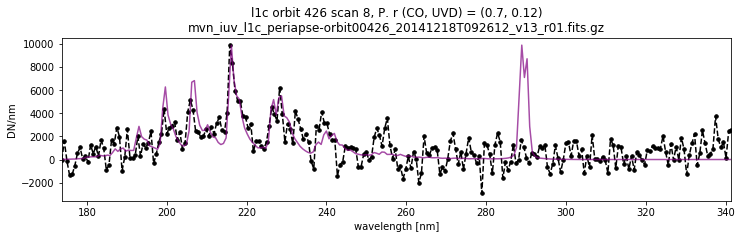

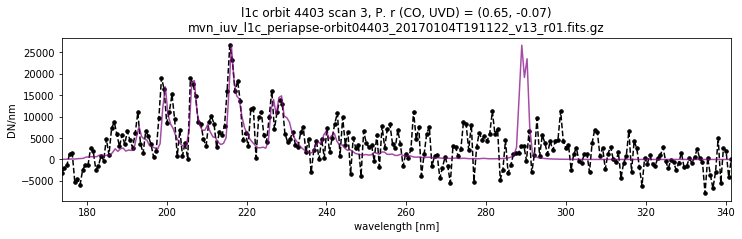

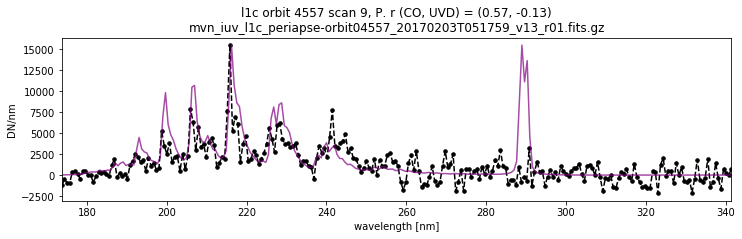

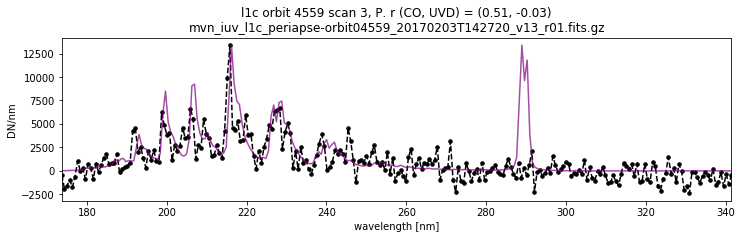

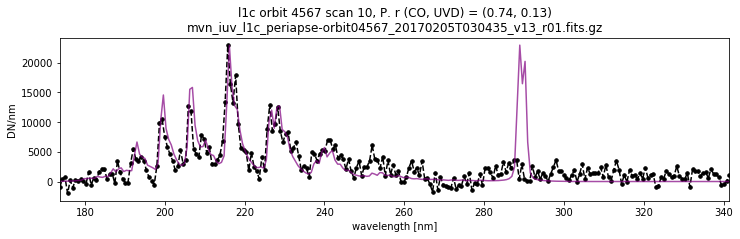

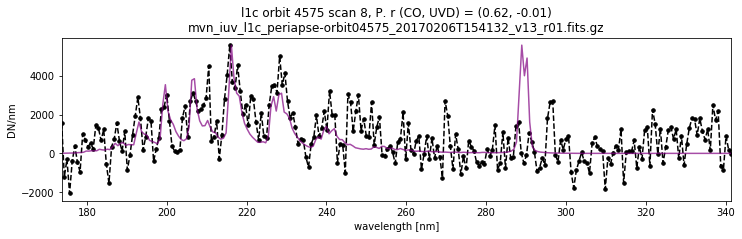

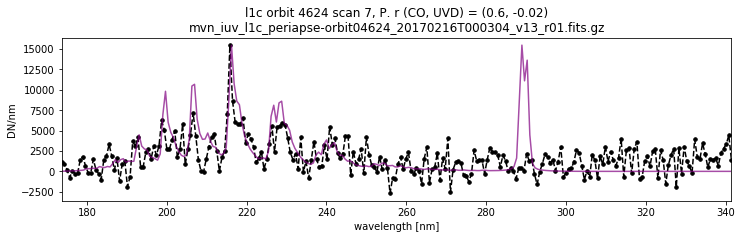

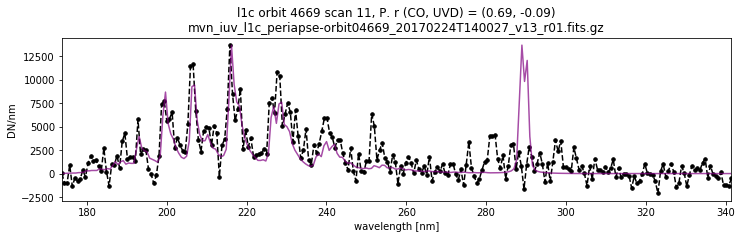

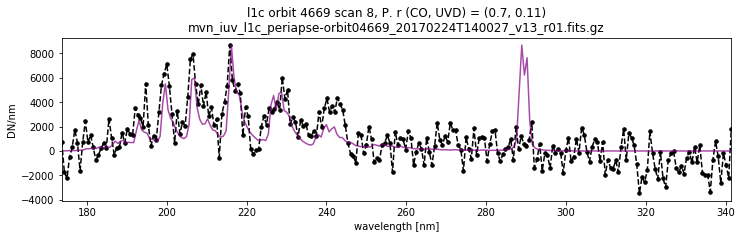

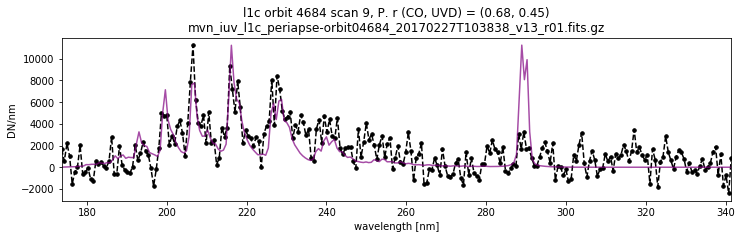

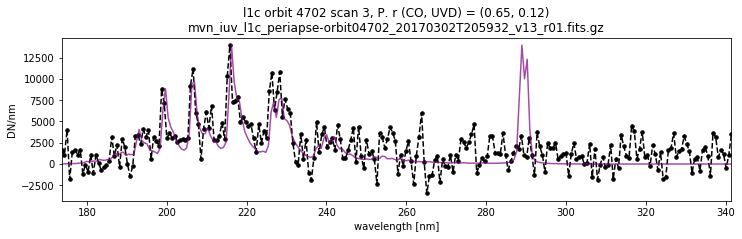

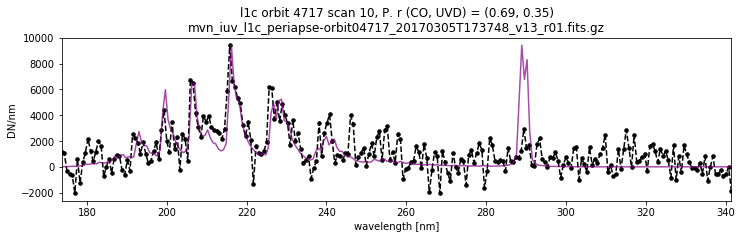

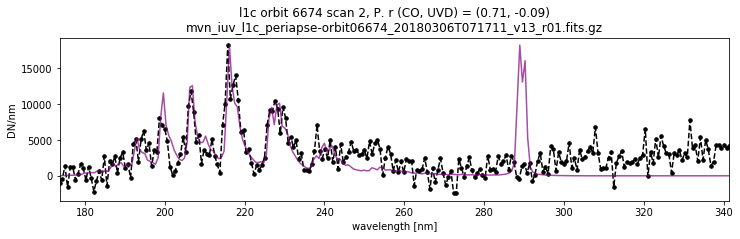

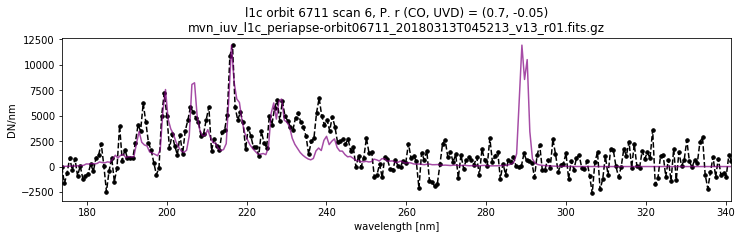

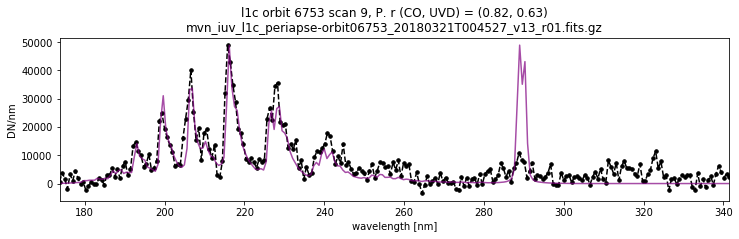

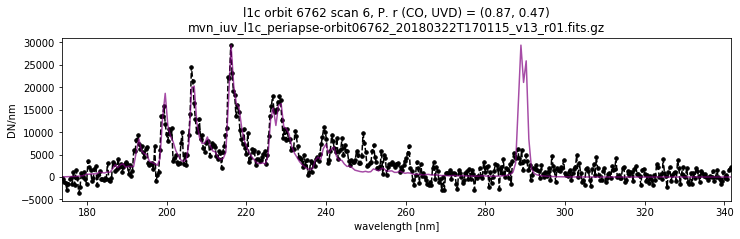

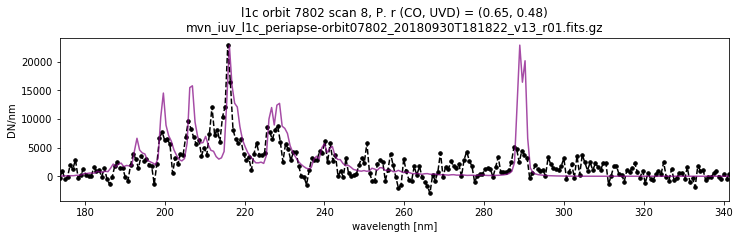

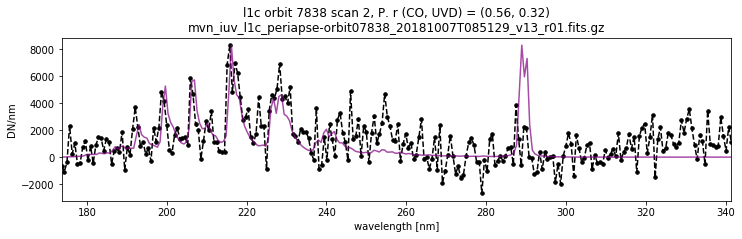

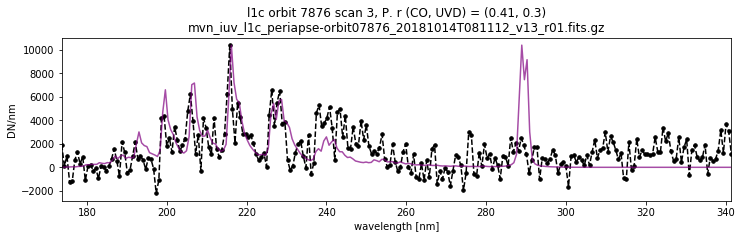

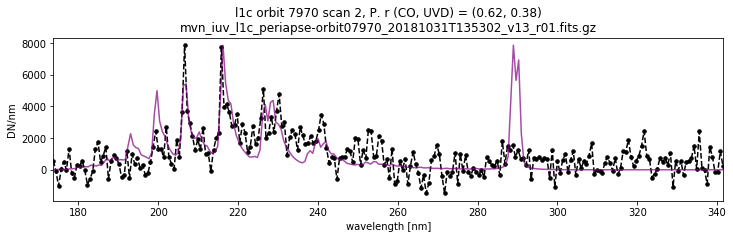

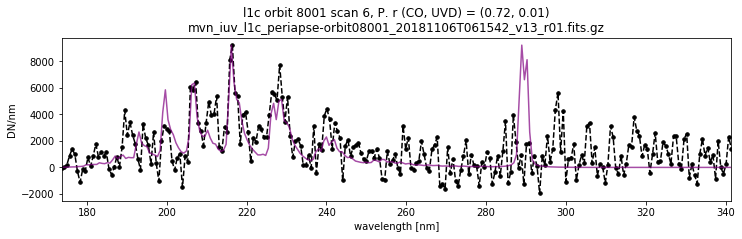

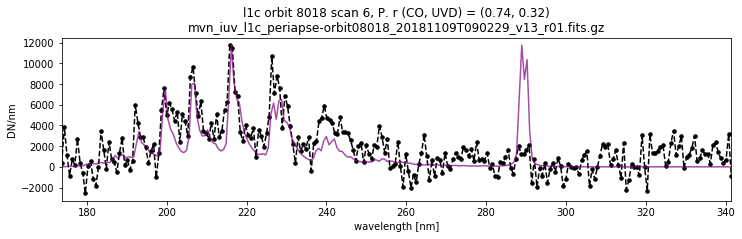

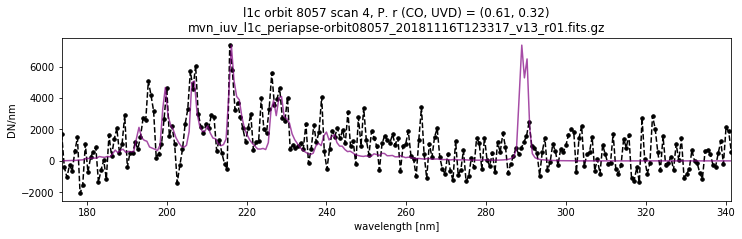

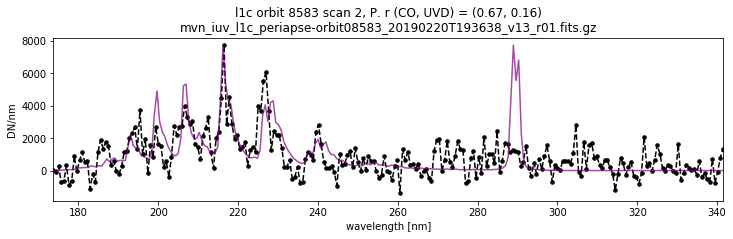

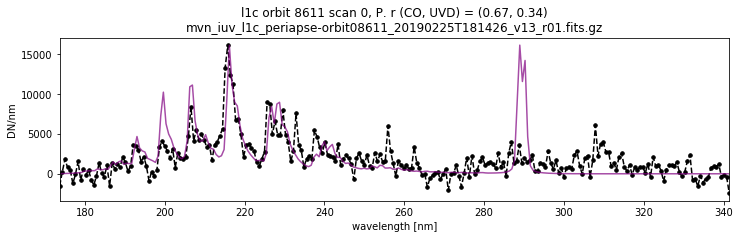

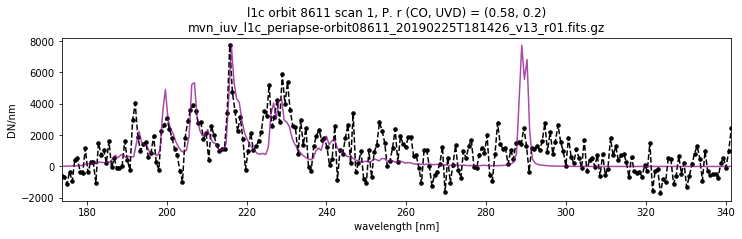

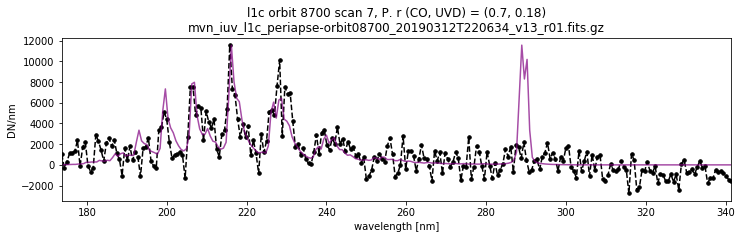

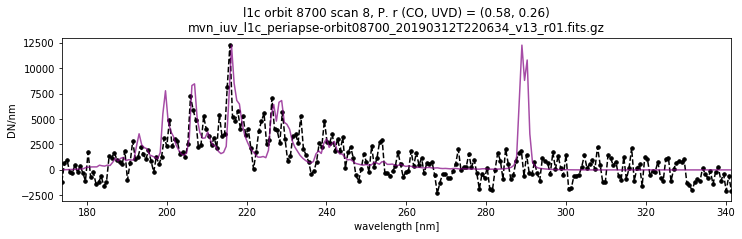

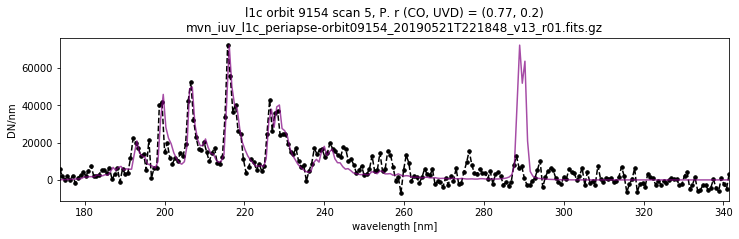

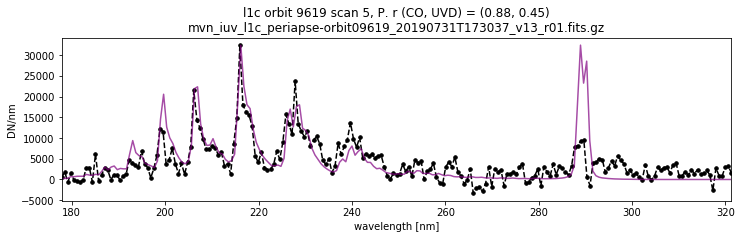

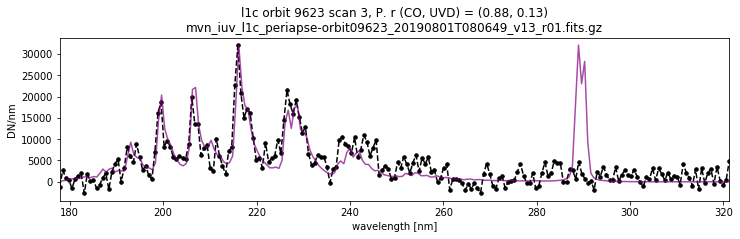

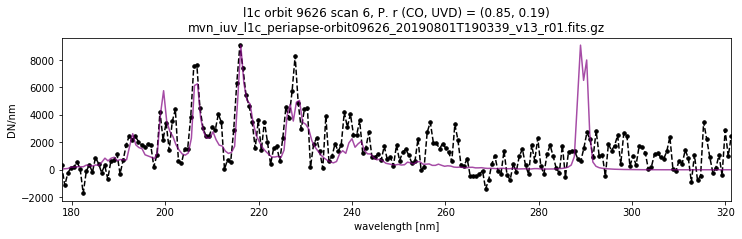

In [9]:
for i in range(len(DN_spectra)):
    plot_spectrum_in_DN_with_templates(DN_wave[i], DN_spectra[i], orbits[i], scans[i], pearsonRs[i], filenames[i])
    plt.show()

In [8]:
def load(orbit,scan):
    spec = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\other_npy_files\limb_analysis_v21_orbit_'+str(orbit)+'scan_'+str(scan-1)+'_withMSOcoords.npy', allow_pickle=True)[3]
    wav = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\other_npy_files\limb_analysis_v21_orbit_'+str(orbit)+'scan_'+str(scan-1)+'_withMSOcoords.npy', allow_pickle=True)[1]
    comlr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\other_npy_files\limb_analysis_v21_orbit_'+str(orbit)+'scan_'+str(scan-1)+'_withMSOcoords.npy', allow_pickle=True)[10]
    uvdmlr = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\other_npy_files\limb_analysis_v21_orbit_'+str(orbit)+'scan_'+str(scan-1)+'_withMSOcoords.npy', allow_pickle=True)[11]
    return spec,wav, comlr,uvdmlr

In [9]:
ds, dw, dco, duvd = load(8675,3)
discw = dw[6:225]
discspec = ds[6:225]

In [10]:
for i in range(len(DN_spectra)):
    print(len(DN_spectra[i]))

512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
256
256
256
256
256
256
256
256
256
256
256
256
256
256
512
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
512
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
256
219
219
219


In [11]:
all_ratios

array([  32.36,   56.62,   23.49,   60.46,   28.32,   17.99,   29.36,
         14.8 ,   13.49,   12.74,   21.75,   21.99,   21.85,   38.26,
         17.86,   16.84,   35.29,   25.91,   45.72,   18.63,   58.6 ,
         60.95,   51.12,   21.38,   34.71,   27.88,   25.95,   19.04,
         40.2 ,   23.1 ,   55.4 ,   66.72,   49.68,   34.04,   42.  ,
         13.68,   12.94,   35.66,  244.99,  -41.43,  153.92,   42.38,
        199.09,   17.09,  -24.76,  -51.45,   29.69,   25.24,   17.15,
         52.78,  -78.5 ,   22.64,  -80.49,   13.44,   18.26,   36.89,
         90.38,   26.2 ,   24.03,   19.91,   24.26,   13.14,   13.09,
         21.52,  -30.32,   17.9 ,   20.89,   18.39,   88.97,   35.36,
         25.13,   20.35,   18.87,   25.09,  118.45,   19.83,   54.58,
         23.11,   19.8 ,   23.58,   20.1 ,   54.39,   74.71, -108.21])

In [12]:
print(len(DN_wave[10][6:225]))

219


In [13]:
for i in range(len(DN_wave)-1):
    if np.shape(DN_wave[i])==(512,):
        new = []
        new2 = []
        for j in range(0,len(DN_wave[i])-1,2):
            new.append(DN_wave[i][j])
            new2.append(DN_spectra[i][j])
        DN_wave[i] = np.array(new)
        DN_spectra[i] = np.array(new2)
    if np.shape(DN_wave[i])==(256,):
        DN_wave[i] = DN_wave[i][6:225]
        DN_spectra[i] = DN_spectra[i][6:225]

In [14]:
allspec = np.sum(DN_spectra,axis=0)

In [15]:
%matplotlib qt
templates = np.load(r'C:\Users\Owner\OneDrive - UCB-O365\Documents\College\LASP\MAVEN\code\l1c_Adrienne_v20_final\maps_and_data_dir\DN_templates\templates_256_DN.npy', allow_pickle=True)
wav_tmpl0 = templates.item()['wavelength']
co_tmpl0 = templates.item()['co_cameron']
uvd_tmpl0 = templates.item()['co2p_uvd']
no_tmpl0 = templates.item()['no_nightglow']
limits = (6, 225) #index 6 on the 256 wavelength template corresponds to 177.84 nm, index 191 corresponds to 299.54 nm
wav_tmpl_cut = wav_tmpl0[limits[0]:limits[1]] #index out the desired section of the wavelength and CO, NO, and UVD templates
co_tmpl_cut = co_tmpl0[limits[0]:limits[1]]
no_tmpl_cut = no_tmpl0[limits[0]:limits[1]]
uvd_tmpl_cut = uvd_tmpl0[limits[0]:limits[1]]
muv_tmpl_cut2 = (co_tmpl_cut+uvd_tmpl_cut) #Add the CO and UVD templates to show at the same time
#Ask Nick about scaling UVD-should UVD be scaled to the same scale as CO emissions or should it be scaled to the UVD feature
#If so, use the following template instead:
muv_tmpl_cut = co_tmpl_cut*np.max(allspec[0:140]) + uvd_tmpl_cut*5.55*np.max(discspec[140:])
#Plot it all
#plt.style.use('dark_background')
plt.figure(figsize=(20,13), dpi=150)
#plt.plot(DN_wave[0], muv_tmpl_cut, 'r-', label= 'Template')
plt.plot(discw,discspec*np.max(allspec)/max(discspec),'b--',label='Discrete Data')
#plt.plot(wav_tmpl_cut, muv_tmpl_cut, 'r--', label='CO & UVD template',linewidth=2)
plt.plot(DN_wave[0], allspec, color='black', label='84 Anomalous emissions summed',linewidth=1)
#plt.hlines(0, xmin=min(dw),xmax=max(dw),linewidth=1)
plt.xlabel('wavelength (nm)',fontsize=20)
plt.ylabel('intensity (DN/nm)',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Anomalous Spectra Summed vs Discrete Emission',fontsize=20)
plt.legend(loc='upper right',fontsize='x-large')
#plt.savefig('sumdisc.jpg');

In [16]:
np.max(allspec)/np.max(discspec)

5.509822058257872

In [52]:
long = []
lat = []
for i in range(len(MSO_lon)):
    long.append(np.mean(MSO_lon[i]))
    lat.append(np.mean(MSO_lat[i]))
long = np.array(long)
lat = np.array(lat)

In [53]:
r=10
theta = np.array(long)*np.pi/180+np.pi/2
phi = (90-lat)*np.pi/180

In [54]:
x = (r*np.sin(phi) *np.cos(theta))
y = (r*np.sin(phi)*np.sin(theta))
z = (r*np.cos(phi))
phii, thetaa = np.mgrid[0.0:np.pi/2:30j, 0.0:2.0*np.pi:30j]
phi2, theta2 = np.mgrid[0.0:np.pi:14j, 0.0:2.0*np.pi:14j]
xx = r*np.sin(phi2)*np.cos(theta2)
yy = (r*np.sin(phi2)*np.sin(theta2))
zz = (r*np.cos(phi2))

In [76]:
rs = []
xs = []
ys = []
angles = [90,100,120,140,160]
#angles = np.arange(90,180,5)
t = np.arange(0,2.1*np.pi,0.1)
for i in range(len(angles)):
    rs.append(np.sin(np.pi*angles[i]/180)*r)
    xs.append(rs[i]*np.cos(t))
    ys.append(rs[i]*np.sin(t))

In [77]:
data=pd.read_csv('master_set.csv')
lss = data['L_s']
ls=lss.values

In [78]:
import math
azimuth = []
for i in range(len(x)):
    if x[i]>0 and z[i]>0:
        azimuth.append(360-(180/np.pi*np.abs(math.atan(x[i]/z[i]))))
    if x[i]>0 and z[i]<0:
        azimuth.append(180+(180/np.pi*np.abs(math.atan(x[i]/z[i]))))
    if x[i]<0 and z[i]<0:
        azimuth.append(90+(180/np.pi*np.abs(math.atan(z[i]/x[i]))))
    if x[i]<0 and z[i]>0:
        azimuth.append(180/np.pi*np.abs(math.atan(x[i]/z[i])))
azimuth = (np.round(np.array(azimuth),2))

In [79]:
bins = np.arange(0,361,30)
plt.figure(figsize=(15,10))
y,binedge = np.histogram(azimuth, bins=bins)
plt.xticks(bins,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Azimuth Angle (degrees)',fontsize=20)
plt.ylabel('Number of Emissions',fontsize=20)
plt.title('Azimuth Angles of Anomalous Emissions', fontsize=25)
bincenters=0.5*(binedge[1:]+binedge[:-1])
std=np.sqrt(y)
plt.bar(bincenters,y,yerr=std,width=30,capsize=5,color='skyblue')
plt.vlines([0,90,180,270],ymin=0,ymax=20, linestyle='dashed', color='red')
plt.text(5,19,'North Pole', fontsize=14)
plt.text(95,19,'Dusk',fontsize=14)
plt.text(185,19,'South Pole', fontsize=14)
plt.text(275,19,'Dawn',fontsize=14);

In [80]:
360-math.atan(x[i]/z[i])

361.3781900585487

In [81]:
%matplotlib qt
fig = plt.figure(figsize=(12.5,10))
#plt.plot(yy,zz,color='skyblue',alpha=0.3)
plt.scatter(x,z,c=ls,cmap=cm.twilight_shifted,s=30)
for i in range(len(xs)):
    plt.plot(xs[i],ys[i],c='blue',alpha=0.2)
for i in range(len(z)):
    plt.text(x[i],z[i],s=str(orbits[i]),color='black',size=6,rotation=45)
plt.xlabel('Local Time')
plt.yticks(np.arange(0,10,10))
plt.ylabel('Latitude');
plt.text(0,10.2,'North Pole',horizontalalignment='center')
plt.text(0,-10.5,'South Pole',horizontalalignment='center')
plt.text(9.8,0,'Dawn')
plt.text(-10.6,0,'Dusk')
plt.text(3,-2.5,'160',horizontalalignment='center')
plt.text(5.25,-4.5,'140',horizontalalignment='center')
plt.text(7,-6,'120',horizontalalignment='center')
plt.text(7.75,-6.75,'100',horizontalalignment='center')
scale = np.arange(0,361,90)
plt.colorbar(ticks=scale)
plt.scatter(0,0,c='black')
plt.text(0,-.5,'Antisolar Point',horizontalalignment='center',fontsize=10)
plt.title('Positions of Anomalous Emissions on Nightside View',fontsize=15)
plt.text(14.75,-7,'Northern Summer')
plt.text(14.75,-1,'Northern Autumn')
plt.text(14.75,5,'Northern Winter')
plt.text(14.75,10.5,'Northern Spring')
plt.text(11.5,-1,'L_s (Season)',rotation='vertical')
#plt.text(12,);

Text(11.5, -1, 'L_s (Season)')

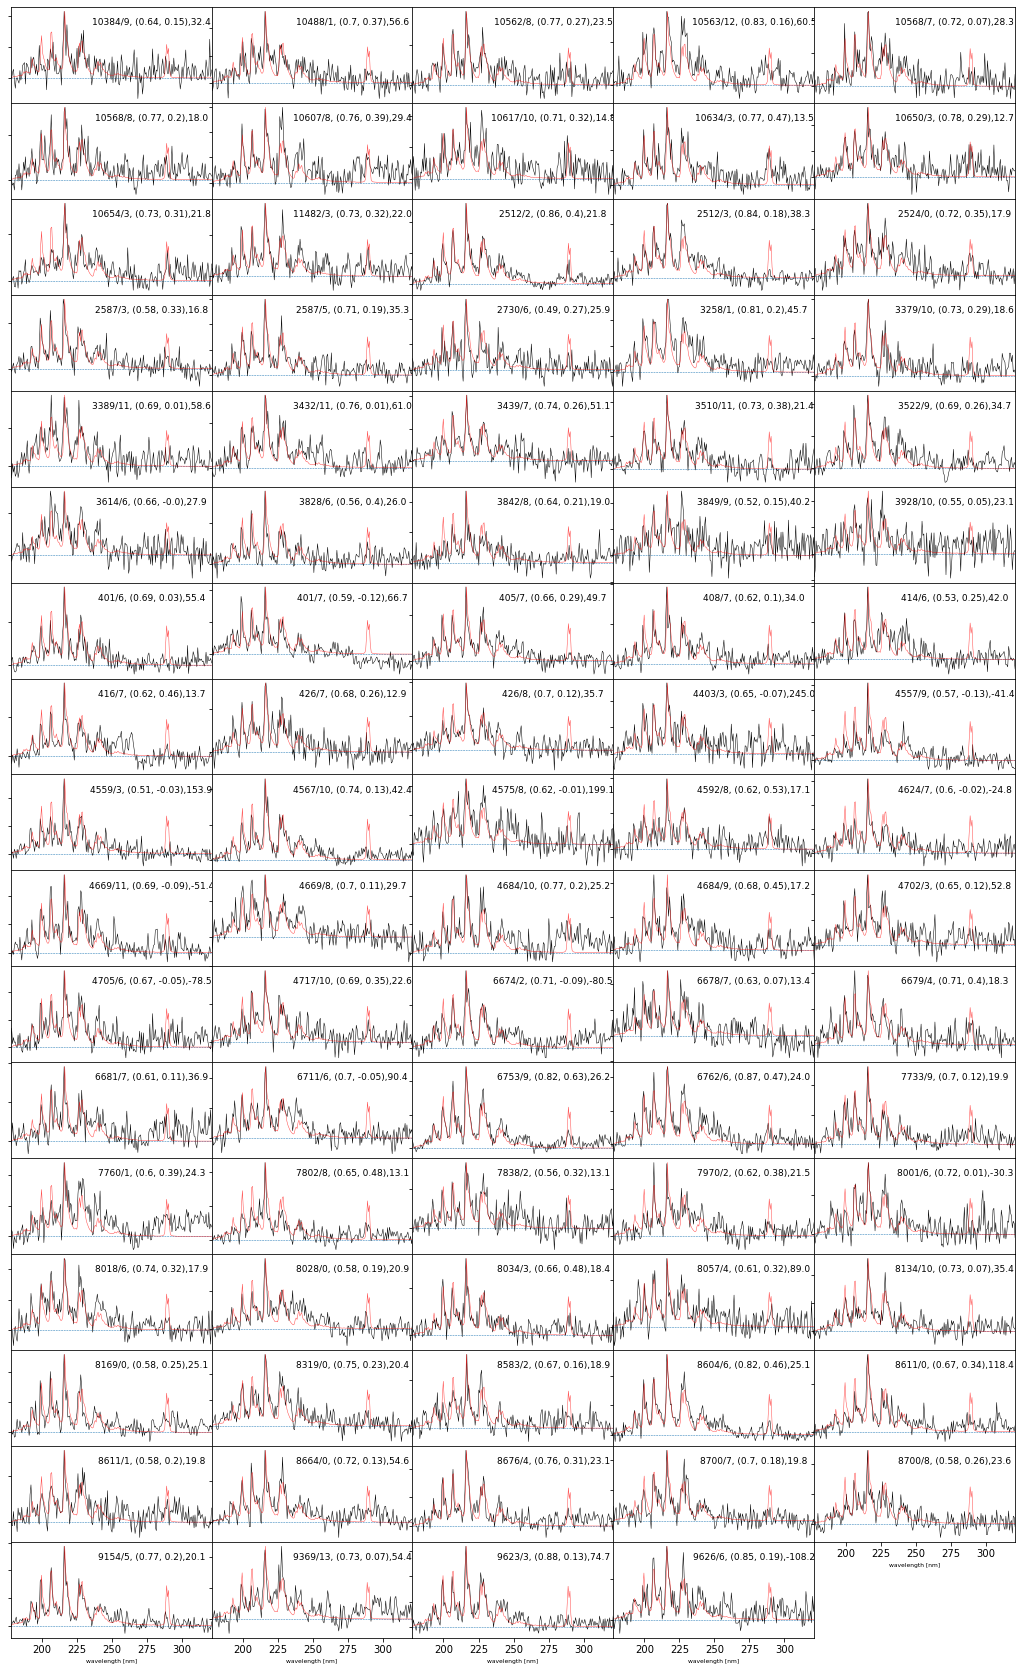

In [43]:
%matplotlib inline
#DN/nm PLOT
fig=plt.figure(figsize=(18,30))
fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in range(len(DN_wave)):
    if DN_wave[i].shape == (364,):
        #use 512 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl512, co_tmpl512, uvd_tmpl512
    else:
        #use 256 bins
        wav_tmpl_DN, co_tmpl_DN, uvd_tmpl_DN = wav_tmpl256, co_tmpl256, uvd_tmpl256
    plt.subplot(17,5,i+1)
    plt.plot(DN_wave[i], DN_spectra[i], c='k',linewidth=0.5)
    if i>40:
        plt.xlabel("wavelength [nm]",fontsize=6)
    if i < 40:
        plt.tick_params(labelbottom=False)
    plt.tick_params(labelleft=False)
    plt.xlim(right=325)
    plt.title(f'{orbits[i]}/{scans[i]}, {pearsonRs[i]},{np.round(all_ratios[i],1)}',x=0.7,y=0.75,fontsize=9)
    dspecscaled = discspec*np.max(DN_spectra[i])/np.max(discspec)
    maxCO = np.max(dspecscaled[:np.where(DN_wave[i] <= 250)[0][-1]])
    maxUVD = np.max(dspecscaled[np.where(DN_wave[i] >= 275)[0][0]:np.where(DN_wave[i] <= 300)[0][-1]])
    plt.xlim(np.nanmin(DN_wave[i]), np.nanmax(DN_wave[i]))                  
    plt.plot(wav_tmpl_DN, co_tmpl_DN*maxCO + uvd_tmpl_DN*maxUVD, color='red', alpha=0.7,linewidth=0.5)
    plt.hlines(0,xmin=min(dw),xmax=max(dw),linewidth=0.5,linestyle='dashed')
    #plt.plot(dw,dspecscaled)
plt.savefig('grid.png')

In [86]:
np.max(dspecscaled[np.where(DN_wave[i] >= 275)[0][0]:np.where(DN_wave[i] <= 300)[0][-1]])

16070.997545236394

In [41]:
j

510

In [8]:
orbits

[10384,
 10488,
 10562,
 10563,
 10568,
 10568,
 10607,
 10617,
 10634,
 10650,
 10654,
 11482,
 2512,
 2512,
 2524,
 2587,
 2587,
 2730,
 3258,
 3379,
 3389,
 3432,
 3439,
 3510,
 3522,
 3614,
 3828,
 3842,
 3849,
 3928,
 401,
 401,
 405,
 408,
 414,
 416,
 426,
 426,
 4403,
 4557,
 4559,
 4567,
 4575,
 4592,
 4624,
 4669,
 4669,
 4684,
 4684,
 4702,
 4705,
 4717,
 6674,
 6678,
 6679,
 6681,
 6711,
 6753,
 6762,
 7733,
 7760,
 7802,
 7838,
 7876,
 7970,
 8001,
 8018,
 8028,
 8034,
 8057,
 8134,
 8169,
 8319,
 8583,
 8604,
 8611,
 8611,
 8664,
 8676,
 8700,
 8700,
 9154,
 9369,
 9623,
 9626]

In [31]:
for i in range(len(pearsonRs)):
    print(orbits[i],np.array(pearsonRs)[i][0], ratios[i])

10384 0.64 32.36290322580646
10488 0.7 56.61774461028192
10562 0.77 23.49428393265434
10563 0.83 60.461504424778774
10568 0.72 28.316352521650533
10568 0.77 17.994148020654045
10607 0.76 29.36282871357498
10617 0.71 14.80222841225627
10634 0.77 13.494947569113442
10650 0.78 12.74222777690986
10654 0.73 21.75204562360526
11482 0.73 21.99472188388145
2512 0.86 21.853987397520154
2512 0.84 38.262628336755654
2524 0.72 17.856168172598196
2587 0.58 16.83820662768031
2587 0.71 35.28755537656061
2730 0.49 25.914498141263948
3258 0.81 45.71514907332797
3379 0.73 18.626498002663116
3389 0.69 58.604509973980896
3432 0.76 60.94834148994019
3439 0.74 51.12305025996534
3510 0.73 21.38127853881279
3522 0.69 34.71022222222223
3614 0.66 27.879349186483104
3828 0.56 25.948162533612194
3842 0.64 19.043135095447873
3849 0.52 40.2
3928 0.55 23.101580135440177
401 0.69 55.40108695652172
401 0.59 66.71954674220964
405 0.66 49.6795466254508
408 0.62 34.039405684754534
414 0.53 42.0015026296018
416 0.62 13.67